# Notebook for Battery Optimization Case Study

## Overview
We have a 1MW, 1MWh battery. 
This means the battery can charge and discharge with a maximum power
of 1 MW. 
The battery can store at most 1 MWh, i.e. after charging with full power for 1h, the battery will be
full. 
To earn money with the battery we buy electricity on the wholesale market when it is cheap to do so
and sell when it is expensive, storing the electricity in the battery in the meantime.

## Importing Packages

In [1]:
import os
import numpy as np
import pandas as pd
from datetime import datetime
from pyomo import environ as en
import lightgbm
import seaborn as sns
import matplotlib.pyplot as plt

## Reading Data 

In [2]:
# set working directory and file paths
working_directory_path=os.path.abspath('') # set working directory path to the folder which contains this notebook
# working_directory_path=/some/other/path uncomment and adjust to set another working directory if above line does not work
data_set_filename=r'\Day-ahead_Prices_60min.csv' # change if the data set has another name, raw string is used just in case the filename should contain chars that need escaping
data_set_path=working_directory_path+data_set_filename # combine working dir and filename

In [3]:
df=pd.read_csv(data_set_path, delimiter=',') # read the data from csv into a pandas data frame

In [4]:
# look at data
df.dtypes

MTU (CET/CEST)                object
Day-ahead Price [EUR/MWh]    float64
Currency                      object
BZN|DE-LU                    float64
dtype: object

In [5]:
df.head()

,MTU (CET/CEST),Day-ahead Price [EUR/MWh],Currency,BZN|DE-LU
0,01.01.2022 00:00 - 01.01.2022 01:00,50.05,EUR,NaN
1,01.01.2022 01:00 - 01.01.2022 02:00,41.33,EUR,NaN
2,01.01.2022 02:00 - 01.01.2022 03:00,43.22,EUR,NaN
3,01.01.2022 03:00 - 01.01.2022 04:00,45.46,EUR,NaN
4,01.01.2022 04:00 - 01.01.2022 05:00,37.67,EUR,NaN


In [6]:
df.describe()

,Day-ahead Price [EUR/MWh],BZN|DE-LU
count,4343.000000,0.0
mean,185.802167,NaN
std,90.656821,NaN
min,-19.040000,NaN
25%,122.150000,NaN
50%,189.000000,NaN
75%,232.935000,NaN
max,700.000000,NaN


In [7]:
# check for nans in price
df[df['Day-ahead Price [EUR/MWh]'].isna()]

,MTU (CET/CEST),Day-ahead Price [EUR/MWh],Currency,BZN|DE-LU
2042,27.03.2022 02:00 - 27.03.2022 03:00,NaN,NaN,NaN


In [8]:
# check for nans in datetime
df[df['MTU (CET/CEST)'].isna()]

,MTU (CET/CEST),Day-ahead Price [EUR/MWh],Currency,BZN|DE-LU


In [9]:
# create new datetime col based on first 16 chars of 'MTU (CET/CEST)'
df['datetime']=pd.to_datetime(df['MTU (CET/CEST)'].str[:16], format="%d.%m.%Y %H:%M")

In [10]:
# check data
df.head()

,MTU (CET/CEST),Day-ahead Price [EUR/MWh],Currency,BZN|DE-LU,datetime
0,01.01.2022 00:00 - 01.01.2022 01:00,50.05,EUR,NaN,2022-01-01 00:00:00
1,01.01.2022 01:00 - 01.01.2022 02:00,41.33,EUR,NaN,2022-01-01 01:00:00
2,01.01.2022 02:00 - 01.01.2022 03:00,43.22,EUR,NaN,2022-01-01 02:00:00
3,01.01.2022 03:00 - 01.01.2022 04:00,45.46,EUR,NaN,2022-01-01 03:00:00
4,01.01.2022 04:00 - 01.01.2022 05:00,37.67,EUR,NaN,2022-01-01 04:00:00


In [11]:
# create date related features for filtering and usage in the prediction model later
df[['year', 'month_name', 'date', 'week', 'day_name', 'hour']] = \
df['datetime'].apply(lambda x: (x.year, x.month_name(), x.date(), x.week, x.day_name(), x.hour)).apply(pd.Series)

In [12]:
# check data
df.head()

,MTU (CET/CEST),Day-ahead Price [EUR/MWh],Currency,BZN|DE-LU,datetime,year,month_name,date,week,day_name,hour
0,01.01.2022 00:00 - 01.01.2022 01:00,50.05,EUR,NaN,2022-01-01 00:00:00,2022,January,2022-01-01,52,Saturday,0
1,01.01.2022 01:00 - 01.01.2022 02:00,41.33,EUR,NaN,2022-01-01 01:00:00,2022,January,2022-01-01,52,Saturday,1
2,01.01.2022 02:00 - 01.01.2022 03:00,43.22,EUR,NaN,2022-01-01 02:00:00,2022,January,2022-01-01,52,Saturday,2
3,01.01.2022 03:00 - 01.01.2022 04:00,45.46,EUR,NaN,2022-01-01 03:00:00,2022,January,2022-01-01,52,Saturday,3
4,01.01.2022 04:00 - 01.01.2022 05:00,37.67,EUR,NaN,2022-01-01 04:00:00,2022,January,2022-01-01,52,Saturday,4


In [13]:
df.to_csv(path_or_buf=r'c:\\Users\\t-matic\\Documents\\GitHub\\entrix\\data.csv')

In [14]:
working_directory_path

'c:\\Users\\t-matic\\Documents\\GitHub\\entrix'

In [15]:
df.dtypes

MTU (CET/CEST)                       object
Day-ahead Price [EUR/MWh]           float64
Currency                             object
BZN|DE-LU                           float64
datetime                     datetime64[ns]
year                                  int64
month_name                           object
date                                 object
week                                  int64
day_name                             object
hour                                  int64
dtype: object

## Case 1.1
For every day in the data, find the profit-maximizing times to charge and discharge the battery.
### Linear Programming Solution
The solution via integer linear programming of this task is identical to Task 1.2, except  
* The battery state in a given time step *t* can only take one of the defined values: 
  * $ Battery State_t \in \{0,1,2\} $

changes to
* The battery state in a given time step *t* can only take one of the defined values: 
  * $ Battery State_t \in \{0,1\} $

and 
* The battery cannot be charged/discharged beyond its limits: 
  * $0 \leq Battery State_t-BatteryAction_t \leq 2$

changes to
* The battery cannot be charged/discharged beyond its limits: 
  * $0 \leq Battery State_t-BatteryAction_t \leq 1$

the code that follows below includes solutions for both batteries.

### "Logical Thinking" Approach/Heuristic 
It makes sense to buy low and sell high. The optimal points of buying and selling energy are given by the local minima and maxima of the day ahead prices respectively. Since by definition, the function between local minima and maxima is monotonic, there is nothing to be gained from buying/selling frequently between those 2 points. It's like hiking/cycling - if you ride up a hill and never go down before reaching the top, your total elevation gain is simply the difference between the highest and the lowest point.
If we start with an empty battery, we use the first local minimum to buy energy and the next local maximum to sell and we repeat that for whatever time window we choose.
In python we could utilize the argrelextrema function from scipy.signal.

## Case 1.2
Suppose we now have a 1 MW, 2 MWh battery. This means the battery can charge for 2 hours with full
power when completely empty and discharge for 2 hours with full power when completely full. 
It can also
charge and discharge to half full by charging/discharging with full power for 1 hour.

### Approach
Optimizing the utilization of our battery is constrained optimization problem. More spefifically it is a integer linear programming (ILP) problem since all variables for which we try to find optimal values will be integers.

First I will describe the problem and then set up the optimization problem with pyomo.
### Problem Description
#### Assumptions
I'm going to make the following assumptions:
 * The battery does not degrade. In reality you need to consider how the battery's efficiency and capacity degrades with every load/discharge action.
 * As shown in Task 1.1, with a non-degrading battery there can be multiple solutions giving the same optimal revenue but different counts of load/discharge actions. 
   * Therefore, I will do the following:
    1. Find the optimal revenue in the given time window T - ignoring the count of the load/discharge actions.
    2. After having found the optimal revenue, a second optimization problem will solve for achieving the optimal revenue with the fewest possible load/discharge actions.

#### Setting up the Problem
##### Battery Action: 
The action the battery takes at every time step *t*. This is the variable for which we will find the optimal value in the end. It can can be either: 
* *Do nothing* which will be encoded as **0**
* *Buy one unit* which will be encoded as **-1**
* *Sell one unit* which will be encoded as  **1**
* Of course the battery itself does not buy and sell anything, we rather instruct the battery to charge, load or do nothing at each time step but it's handy to summarize this as buying/selling. *Unit* refers to **1MWh**

From the above we get $Battery Action Set = \{-1,0,1\}$ and $BatteryAction_t \in \{-1,0,1\}$
##### Battery State:
The number of units the battery can hold at every time step *t* which can be either 0, 1 or 2 which gives $Battery State_t \in \{0,1,2\}$
##### Revenue/Profit and the Objective Function
Since no costs are given, Revenue equals Profit. The day-ahead-price in EUR per MhW will simply be referred to as **Price**. The revenue at each time step *t* is then given by 

$$
\displaystyle Revenue_t=Price_t \times BatteryAction_t
$$

Since we want to maximize revenue in a given time window *T*, the objective function becomes
$$
\displaystyle Revenue=\sum_{t=1}^T Revenue_t
$$

##### Constraints
Having worked out the variable we want to find optimal values for and the objective function, we now set up the constraints.

* The battery state in a given time step *t* can only take one of the defined values: 
  * $ Battery State_t \in \{0,1,2\} $
* The battery action in a given time step *t* can only take one of the defined values: 
  * $ BatteryAction_t \in \{-1,0,1\} $
* The battery cannot be charged/discharged beyond its limits: 
  * $0 \leq Battery State_t-BatteryAction_t \leq 2$
* If $t>1$, the battery state at t depends on the pervious battery state and previous battery action:
  * $Battery State_t=Battery State_{t-1}-BatteryAction_{t-1} \text{ if } t>1$

##### The Complete Optimization Problem for Maximizing Revenue
Combining everything from above, the complete optimization problem looks like this:
$$
\begin{equation*}
 \begin{aligned}
 & \underset{BatteryAction_t}{\text{max}}
 & \sum_{t=1}^T \text{Price}_t \times \text{BatteryAction}_t \\
 & \text{subject to} & \text{Battery State}_t \in \{0,1,2\} \\
 & & BatteryAction_t \in \{-1,0,1\} \\
 & & 0 \leq Battery State_t-BatteryAction_t \leq 2 \\
 & & Battery State_t=Battery State_{t-1}-BatteryAction_{t-1} \text{ if } t>1
 \end{aligned}
\end{equation*}
$$

From solving this problem we will get $\text{Revenue}_{max}$. As shown in Task 1.1, there can be multiple solutions that yield $\text{Revenue}_{max}$ but use a higher count of Battery Actions.
We will modify the objective function so we get $\text{Revenue}_{max}$ with the lowest count of Battery Actions.

Battery Action Count will be defined as:
 * $\sum_{t=1}^T |\text{BatteryAction}_t|$

The modified objective function becomes:
$$
-\big | \text{Revenue}_{max} - \sum_{t=1}^T \text{Revenue}_t \big | \times BigNumber - \sum_{t=1}^T \text{BatteryAction}_t
$$

How does it work? $\big | \text{Revenue}_{max} - \sum_{t=1}^T \text{Revenue}_t \big |$ is the penalty activation condition for not achieving $\text{Revenue}_{max}$. It is multiplied by $BigNumber$ and $BigNumber$ is chosen to be large enough that it will never be feasible to sacrifice Revenue to reduce Battery Action Count. Only if Revenue is maximized, Battery Action Count will be minimized since $BigNumber$ is multiplied by 0.
The constraints stay the same as above.
Having reviewed the solutions by the solver when I had coded the problem below, it does not seem like the solver produces any unnecessary battery actions so I did not code the modified objective function below.

### Coding the Problem

In [16]:
# I will use a single day to set-up and test the optimization
# later we can use any time frame we like
test_date=datetime.strptime('2022-01-01', '%Y-%m-%d').date()
df_test = df.query('date==@test_date')

In [17]:
df_test.head()

,MTU (CET/CEST),Day-ahead Price [EUR/MWh],Currency,BZN|DE-LU,datetime,year,month_name,date,week,day_name,hour
0,01.01.2022 00:00 - 01.01.2022 01:00,50.05,EUR,NaN,2022-01-01 00:00:00,2022,January,2022-01-01,52,Saturday,0
1,01.01.2022 01:00 - 01.01.2022 02:00,41.33,EUR,NaN,2022-01-01 01:00:00,2022,January,2022-01-01,52,Saturday,1
2,01.01.2022 02:00 - 01.01.2022 03:00,43.22,EUR,NaN,2022-01-01 02:00:00,2022,January,2022-01-01,52,Saturday,2
3,01.01.2022 03:00 - 01.01.2022 04:00,45.46,EUR,NaN,2022-01-01 03:00:00,2022,January,2022-01-01,52,Saturday,3
4,01.01.2022 04:00 - 01.01.2022 05:00,37.67,EUR,NaN,2022-01-01 04:00:00,2022,January,2022-01-01,52,Saturday,4


In [18]:
# set up the battery
# we will use this class to easily create instances of the 2 types of battery
# from the problem set
class Battery:
    def __init__(self,
                 battery_state_min,
                 battery_state_max,
                 battery_action_set=[-1,0,1],
                 battery_initial_state=0,
                 battery_initial_action=0):
                 self.battery_state_min=battery_state_min
                 self.battery_state_max=battery_state_max
                 self.battery_action_set=battery_action_set
                 self.battery_initial_state=battery_initial_state
                 self.battery_initial_action=battery_initial_action

In [19]:
# create the 1MW, 2MWh battery
battery_1mw_2mwh=Battery(battery_state_min=0, battery_state_max=2)

In [20]:
# create the 1MW, 1MWh battery
battery_1mw_1mwh=Battery(battery_state_min=0, battery_state_max=1)

In [21]:
# set up a function for creating the problem
def create_optimization_problem(battery, model, price_df, price_var_name='Day-ahead Price [EUR/MWh]'):
    # create dict for day ahead price to use it as parameter in the model
    price_dict=dict(enumerate(price_df[price_var_name]))

    # set up time frame length T
    T=price_df.shape[0]

    # create time index for model
    model.Time=en.RangeSet(0, T-1)

    # create battery action variable 
    model.battery_action=en.Var(model.Time, 
                                domain=battery.battery_action_set, 
                                bounds=(min(battery.battery_action_set), max(battery.battery_action_set)), 
                                initialize=battery.battery_initial_action)
    
    # create battery state variable
    model.battery_state=en.Var(model.Time, 
                           domain=en.NonNegativeIntegers,
                           initialize=battery.battery_initial_state, 
                           bounds=(battery.battery_state_min,battery.battery_state_max))

    # create price parameter
    model.price=en.Param(model.Time, initialize=price_dict, domain=en.Any)

    # create objective function that is going to be maximized
    def revenue(model):
        total_revenue_in_time_frame=sum(model.price[t]*model.battery_action[t] for t in model.Time)
        return total_revenue_in_time_frame
    model.revenue=en.Objective(rule=revenue, sense=en.maximize)

    # create battery state update rule
    def battery_state_update(model, t):
        if t==0:
            return model.battery_state[t]==0 # set initial load of battery
        else:
            return model.battery_state[t]==model.battery_state[t-1]-model.battery_action[t-1]
    model.battery_state_update=en.Constraint(model.Time, rule=battery_state_update)

    # battery can not over charge/discharge
    def battery_charge_lower_limit_rule(model, t):
        return battery.battery_state_min<=model.battery_state[t]-model.battery_action[t]

    model.battery_charge_lower_limit=en.Constraint(model.Time, rule=battery_charge_lower_limit_rule)

    # battery can not over charge/discharge
    # battery can not over charge/discharge
    def battery_charge_upper_limit_rule(model, t):
        return battery.battery_state_max>=model.battery_state[t]-model.battery_action[t]

    model.battery_charge_upper_limit=en.Constraint(model.Time, rule=battery_charge_upper_limit_rule)

    #print(T)
    #print(len(price_dict))

    return model

In [22]:
# remove row with nan for price
# we need to reset the index, otherwise results will not align since we removed 1 hour
df_clean=df[df['Day-ahead Price [EUR/MWh]'].notna()].copy(deep=True).reset_index(drop=True)
# df_clean=df

In [23]:
# create one model per battery
model_1mw_2mwh=create_optimization_problem(battery=battery_1mw_2mwh, model=en.ConcreteModel(), price_df=df_clean)

In [24]:
# create one model per battery
model_1mw_1mwh=create_optimization_problem(battery=battery_1mw_1mwh, model=en.ConcreteModel(), price_df=df_clean)

In [25]:
# create optimizer
optimizer=en.SolverFactory('glpk')

In [26]:
# solve model for each battery
results_1mw_2mwh=optimizer.solve(model_1mw_2mwh)

In [27]:
results_1mw_1mwh=optimizer.solve(model_1mw_1mwh)

In [28]:
# look at objective function value
en.value(model_1mw_2mwh.revenue)

69707.68999999996

In [29]:
en.value(model_1mw_1mwh.revenue)

38031.349999999984

In [30]:
# get variable values and put them in the data frame
df_clean['battery_action_1mw_1mwh']=model_1mw_1mwh.battery_action.extract_values()
df_clean['battery_state_1mw_1mwh']=model_1mw_1mwh.battery_state.extract_values()

In [31]:
# get variable values and put them in the data frame
df_clean['battery_action_1mw_2mwh']=model_1mw_2mwh.battery_action.extract_values()
df_clean['battery_state_1mw_2mwh']=model_1mw_2mwh.battery_state.extract_values()

In [32]:
# visualize solution


In [33]:
df_clean.head()

,MTU (CET/CEST),Day-ahead Price [EUR/MWh],Currency,BZN|DE-LU,datetime,year,month_name,date,week,day_name,hour,battery_action_1mw_1mwh,battery_state_1mw_1mwh,battery_action_1mw_2mwh,battery_state_1mw_2mwh
0,01.01.2022 00:00 - 01.01.2022 01:00,50.05,EUR,NaN,2022-01-01 00:00:00,2022,January,2022-01-01,52,Saturday,0,0.0,0.0,0.0,0.0
1,01.01.2022 01:00 - 01.01.2022 02:00,41.33,EUR,NaN,2022-01-01 01:00:00,2022,January,2022-01-01,52,Saturday,1,-1.0,0.0,-1.0,0.0
2,01.01.2022 02:00 - 01.01.2022 03:00,43.22,EUR,NaN,2022-01-01 02:00:00,2022,January,2022-01-01,52,Saturday,2,0.0,1.0,0.0,1.0
3,01.01.2022 03:00 - 01.01.2022 04:00,45.46,EUR,NaN,2022-01-01 03:00:00,2022,January,2022-01-01,52,Saturday,3,1.0,1.0,1.0,1.0
4,01.01.2022 04:00 - 01.01.2022 05:00,37.67,EUR,NaN,2022-01-01 04:00:00,2022,January,2022-01-01,52,Saturday,4,-1.0,0.0,-1.0,0.0


In [34]:
# function to plot solution for a single day
def plot_solution_for_a_day(df, date, battery_type):


    if battery_type=='1mw_1mwh':
        battery_action='battery_action_1mw_1mwh'
        battery_state='battery_state_1mw_1mwh'
    
    if battery_type=='1mw_2mwh':
        battery_action='battery_action_1mw_2mwh'
        battery_state='battery_state_1mw_2mwh'

    date_parsed=datetime.strptime(date, '%Y-%m-%d').date() # parse date 
    df_test = df.query('date==@date_parsed') # filter on parsed date
    plt.style.use('ggplot')
    fig=plt.figure(1)
    ax1=fig.add_subplot(111) # trick to use fig legend conviniently 
    ax2=ax1.twinx() # dual y-axis for battery action
    ax3=ax1.twinx() # dual y-axis for battery state
    ax1.plot(df_test['hour'], df_test['Day-ahead Price [EUR/MWh]'], color='g', label='Price')
    ax2.plot(df_test['hour'], df_test[battery_action], marker='o', linestyle='', color='b', label='Battery Action')
    ax2.step(df_test['hour'], df_test[battery_state], color='r', where='post', label='Battery State')
    fig.legend(loc="upper right")
    ax2.set_yticks([-1,0,1,2])
    ax3.set_yticks([])
    ax1.set_ylabel("Price")
    ax1.set_xlabel("Hour")
    ax2.set_ylabel("Battery Action/Battery State")
    plt.show()


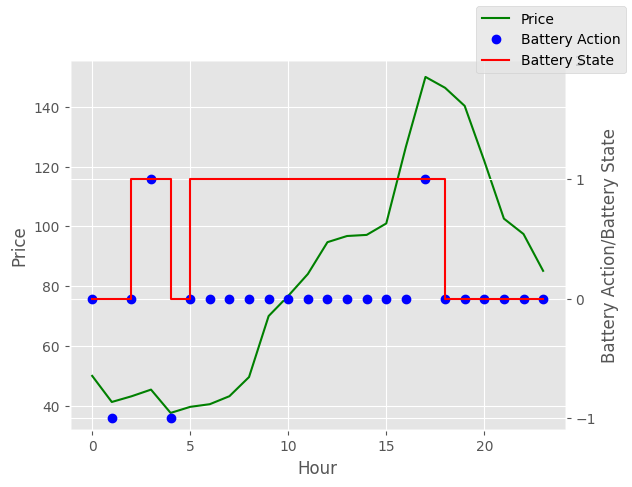

In [35]:
plot_solution_for_a_day(df=df_clean, date='2022-01-01', battery_type='1mw_1mwh')

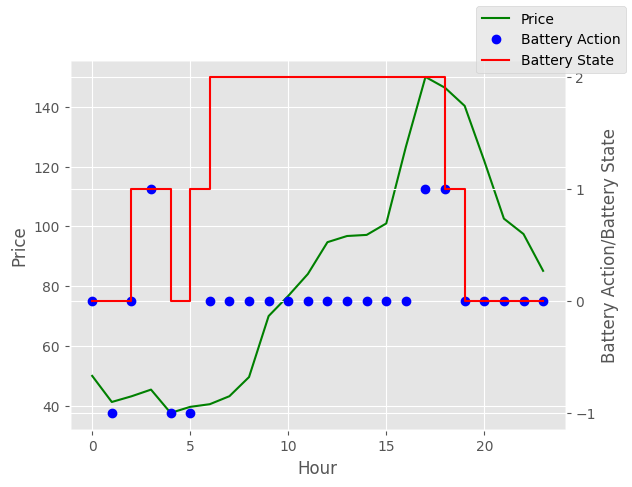

In [36]:
plot_solution_for_a_day(df=df_clean, date='2022-01-01', battery_type='1mw_2mwh')

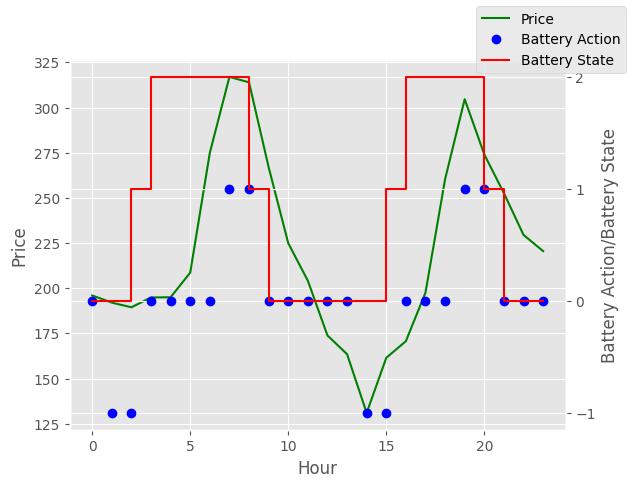

In [37]:
plot_solution_for_a_day(df=df_clean, date='2022-03-28', battery_type='1mw_2mwh')

In [38]:
date_parsed=datetime.strptime('2022-03-28', '%Y-%m-%d').date() # parse date 
df_test = df_clean.query('date==@date_parsed') # filter on parsed date

In [39]:
df_test.to_csv(r"C:\Users\t-matic\Documents\GitHub\entrix\data_test.csv")

## Case 2
Suppose you have to decide at the beginning of each day the times at which you are going to charge and
discharge, without any knowledge of the future, i.e., any price information of that day or future days. You do
have information about past prices.

### Intro
I will briefly describe the more general challenge of finding an optimal trading strategy based on forecasted values before restricting the problem on the 1MW, 1MHw battery.
### General Thoughts
The optimization problem does not care if the price parameters are forecasted or not. If our forecast was perfect, we end up with the optimal trading strategy. So a perfect forecast is sufficient to derive the optimal trading strategy.
The question is, do we need perfect forecasts to derive the optimal trading strategy? Is an optimal forecast a necessity?
Let's consider an example: 
  * If the prices where all shifted up by the same value or multiplied by a single positive scalar, it would not change our optimal trading strategy. We found 2 potential transformations which would not influence our trading strategy, so the forecast does not have to be perfect.

The tricky question in the general case is: What transformations can we apply to the time series and/or how should we design the loss function of our prediction algorithm so it focuses on the parts that are necessary for finding the optimal trading strategy? If we try to predict the actual values with no transformations and we use mean squared error as the loss function, it could happen that we always predict values close to the overall average, which is technically a "good" prediction but not very useful for deploying an optimal trading strategy. 

It could also be worth investigating making the optimization problem explicitly part of the the forecasting problem. E.g. the loss function could become the difference of the optimal trading strategy revenue given the true values and the optimal trading strategy given forecasted values. A starting point could be this paper https://arxiv.org/abs/2206.14234. However, this is out of scope for the assignment. 

### Forecasting and Optimizing for the 1MW, 1MWH battery
As shown in the previous tasks, the optimal trading strategy is to buy low and sell high. Therefore, it is sufficient to know the location of the local minima and maxima - their actual value does not matter. However, one could argue that since we won't be able to forecast the locations perfectly, forecasting locations with a potential big gap precisely might be more beneficial than forecasting locations with small gaps. 

Therefore I will apply 3 different forecasts and compare revenue on a test set for each.
 * Forecast absolute values
 * Forecast the scaled rank values
   * The highest price value will get the highest rank (e.g. 83 if there are 83 distinct prices). The rank values will be scaled between 0 and 1.
   * This will keep the shape of the time series but it will be less prone to shifts and multiplications in amplitude.


#### Train and Test Data Set-Up and Feature Selection
We have hourly data and it makes sense to assume that there are seasonal effects on hour, day and month level and that those effects also interact with each other. E.g. a Monday might have higher average prices than a Sunday and maybe Monday Evening prices are higher than Monday prices around noon and maybe morning prices are rather high except on weekends. In general it would make sense to try to enrich the data with external information like external shock events (e.g. start of the war), even though we do not have future information of those external events for forecasting, they can be beneficial to reduce bias caused by left-out explantory variables. For example, if an external event caused the prices to increase for 3 weeks in April, than a model not having this information might attribute the spike to "it is April" and forecast a spike for the next April again although April itself has nothing to with it, rather it is "the event happened in April" but it could have happened any other month. For this task, adding external data is out of scope. 

However, I will be doing the following: Since I was able to find the source of the data https://www.energy-charts.info/charts/price_spot_market/chart.htm?l=en&c=DE&interval=year&year=2022, I will use the whole year of 2022 as training data to get all the seasonal effects of the months. My test set will be data from 2023 https://www.energy-charts.info/charts/price_spot_market/chart.htm?l=en&c=DE&interval=year&year=2023.


#### Data Explortation for Forecasting

In [40]:
# function for preparing data from 
# https://www.energy-charts.info/charts/price_spot_market/chart.htm?l=en&c=DE&interval=year&year=2022
def prepare_price_data(df, price_var):
    df['datetime']=pd.to_datetime(df['Date (GMT+1)'], format='ISO8601', errors='coerce')
    
    # create date related features for filtering and usage in the prediction model later
    df[['year', 'month_name', 'date', 'week', 'day_name', 'hour']] = \
    df['datetime'].apply(lambda x: (x.year, x.month_name(), x.date(), x.week, x.day_name(), x.hour)).apply(pd.Series)
    
    # remove all obs without any date information
    df=df[df['datetime'].notna()].copy(deep=True).reset_index(drop=True)
    df=df[df[price_var].notna()].copy(deep=True).reset_index(drop=True)

    # create price rank feature
    df['price_rank']=df[price_var].rank(pct=True)

    # location of minima and maxima (which will be the optimal battery actions)
    model_1mw_1mwh_full=create_optimization_problem(battery=battery_1mw_1mwh, model=en.ConcreteModel(), price_df=df, price_var_name=price_var)
    results_model_1mw_1mwh_full=optimizer.solve(model_1mw_1mwh_full)  
    df['battery_action']=model_1mw_1mwh_full.battery_action.extract_values()

    # dict to map battery action to point label
    battery_action_remap={-1:'Local Min',
                        0:'Regular Point',
                        1:'Local Max'}

    # create point label var
    df['point_label']=df['battery_action'].map(battery_action_remap)

    return df

In [41]:
# function for preparing X and y for forecasting
def prepare_x_y(df, X_vars=['month_name', 'day_name', 'hour'], categorical_features=['month_name', 'day_name'], y_raw_price=['Day Ahead Auction'], y_price_rank_scaled=['price_rank'], y_price_point_label=['point_label']):
    X = df[X_vars]
    
    # convert obj to category
    for c in categorical_features:
        X[c] = X[c].astype('category')

    y_price_point_label=np.ravel(df[y_price_point_label])
    y_raw_price=df[y_raw_price]
    y_price_rank_scaled=df[y_price_rank_scaled]

    return X, y_raw_price, y_price_rank_scaled, y_price_point_label

In [42]:
# I will look at how the price distribution varies conditional on hour, day, month, etc
import seaborn as sns

In [43]:
# import data for the full year of 2022
data_set_filename=r'\day_ahead_60_minute_2022.csv' # change if the data set has another name, raw string is used just in case the filename should contain chars that need escaping
data_set_path=working_directory_path+data_set_filename # combine working dir and filename

In [44]:
df_2022_full=pd.read_csv(data_set_path, delimiter=',', 
                         header=0, skiprows=range(1,2))

In [45]:
price_var='Day Ahead Auction'

In [46]:
# prepare data
df_train=prepare_price_data(df=df_2022_full, price_var=price_var)

In [47]:
df_train.head()

,Date (GMT+1),Nuclear,Non-Renewable,Renewable,Day Ahead Auction,datetime,year,month_name,date,week,day_name,hour,price_rank,battery_action,point_label
0,2022-01-01T00:00+01:00,3201.78,9512.95,38544.55,50.05,2022-01-01 00:00:00+01:00,2022.0,January,2022-01-01,52.0,Saturday,0.0,0.057936,0.0,Regular Point
1,2022-01-01T01:00+01:00,3344.15,9444.18,37282.47,41.33,2022-01-01 01:00:00+01:00,2022.0,January,2022-01-01,52.0,Saturday,1.0,0.050851,-1.0,Local Min
2,2022-01-01T02:00+01:00,3340.75,9383.19,35972.17,43.22,2022-01-01 02:00:00+01:00,2022.0,January,2022-01-01,52.0,Saturday,2.0,0.051766,0.0,Regular Point
3,2022-01-01T03:00+01:00,3341.08,9356.06,34534.05,45.46,2022-01-01 03:00:00+01:00,2022.0,January,2022-01-01,52.0,Saturday,3.0,0.053937,1.0,Local Max
4,2022-01-01T04:00+01:00,3335.16,9373.79,33184.47,37.67,2022-01-01 04:00:00+01:00,2022.0,January,2022-01-01,52.0,Saturday,4.0,0.048223,-1.0,Local Min


<Axes: xlabel='Day Ahead Auction', ylabel='day_name'>

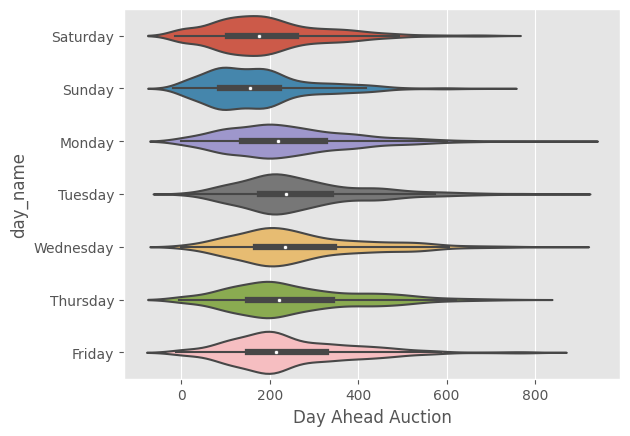

In [48]:
# look at distributions of price conditional on time features
sns.violinplot(data=df_train, x=price_var, y="day_name")

<Axes: xlabel='hour', ylabel='Day Ahead Auction'>

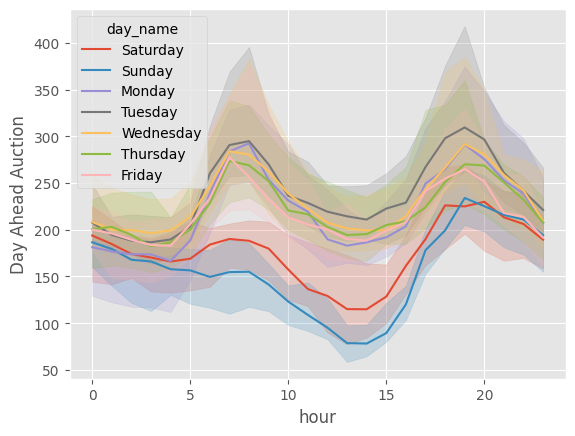

In [49]:
# hourly dist by weekday
sns.lineplot(data=df_train, x="hour", y=price_var, estimator=np.median, hue='day_name')
# hourly trends differ between week days and week end

<Axes: xlabel='hour', ylabel='Day Ahead Auction'>

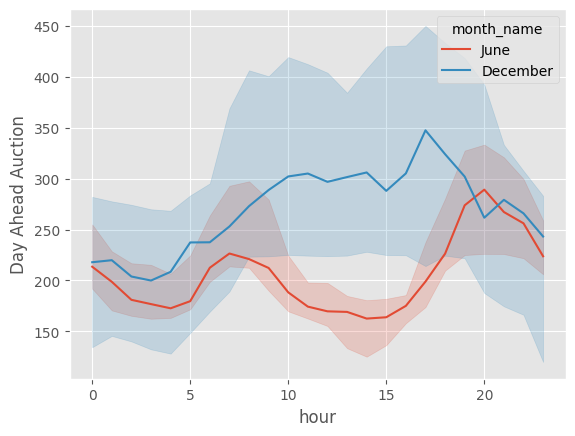

In [50]:
# Look if there is an effect of natural light by comparing the June and December
june_december=['June', 'December']
sns.lineplot(data=df_train.query("month_name in @june_december"), x="hour", y=price_var, estimator=np.median, hue='month_name')
# Phase and amplitude shifts 

##### Choice of Algorithm
From the quick exploration we see that the forecast needs to be conditional on hour, day and month.
The most simple approach would be just using a summary statistic (mean or median) for the price and group the data by hour, day and month. 
Those values will be our forecasts. 

Advantages:
 * Very simple to compute and to understand.
 * Full transparency of how the forecast is made.

Disadvantages:
 * Gets more complex if more features like shock events are added.
   * Will end-up in hand-crafted decision rules which are time consuming to come up with and code.

Gradient-Boosted trees are a solid choice since they can find feature interactions and implicitly find the optimal rules for forecasting. Their drawback is that they struggle with extrapolating but since the training data contains a whole year, we will not have to predict for a new 25th hour of the day or an additional week day or month that was not in the training data.

There are other methods like classic time series techniques like (S)ARIMA which can handle trends and seasonality but it becomes a hassle to model this if we have shifting seasonality effects (i.e. the effect of hour varies by day and by month).
There is also a specialized general additive model (GAM) from facebook which is called prophet but like ARIMA and normal GAMs, it has also the problem that we would need to explicitly model the interaction terms and decide if effects are additive or multiplicative which could be solved by log transformations but this can also become tricky if we need the model to deal with negative prices.

Of course, you would need to try and test them all but this is out scope and I will decide using Gradient Boosting (LightGBM) with some hyperparam tuning via cross-validation.

##### Preparing/Transforming Data


In [51]:
# create X_train and y_train
X_train, y_raw_price_train, y_price_rank_scaled_train, y_price_point_label_train = prepare_x_y(df_train)

C:\Users\t-matic\AppData\Local\Temp\ipykernel_31356\1423873865.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[c] = X[c].astype('category')
C:\Users\t-matic\AppData\Local\Temp\ipykernel_31356\1423873865.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[c] = X[c].astype('category')


#### Train Regression Models

In [52]:
# create regressors
reg_price_rank=lightgbm.LGBMRegressor()
reg_price_raw=lightgbm.LGBMRegressor()

In [53]:
# train regressors
reg_price_rank.fit(X_train, y_price_rank_scaled_train)
reg_price_raw.fit(X_train, y_raw_price_train)

LGBMRegressor()

In [54]:
# load test data and predict on test data
data_set_filename=r'\day_ahead_60_minute_2023.csv' # change if the data set has another name, raw string is used just in case the filename should contain chars that need escaping
data_set_path=working_directory_path+data_set_filename # combine working dir and filename
# read test data
df_2023_full=pd.read_csv(data_set_path, delimiter=',', 
                         header=0, skiprows=range(1,2))

In [55]:
df_test=prepare_price_data(df=df_2023_full, price_var='Day Ahead Auction')

In [56]:
X_test, y_raw_price_test, y_price_rank_scaled_test, y_price_point_label_test = prepare_x_y(df_test)

C:\Users\t-matic\AppData\Local\Temp\ipykernel_31356\1423873865.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[c] = X[c].astype('category')
C:\Users\t-matic\AppData\Local\Temp\ipykernel_31356\1423873865.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[c] = X[c].astype('category')


In [57]:
# predict on test set
df_test['price_rank_pred']=reg_price_rank.predict(X_test)
df_test['price_raw_pred']=reg_price_raw.predict(X_test)

In [58]:
# with the predicted values, we now get the optimal battery actions
predicted_plan_price_raw=create_optimization_problem(battery=battery_1mw_1mwh, model=en.ConcreteModel(), price_df=df_test, price_var_name='price_raw_pred')
results_predicted_plan_price_raw=optimizer.solve(predicted_plan_price_raw)  
df_test['battery_action_predict_price_raw']=predicted_plan_price_raw.battery_action.extract_values()

predicted_plan_price_rank=create_optimization_problem(battery=battery_1mw_1mwh, model=en.ConcreteModel(), price_df=df_test, price_var_name='price_rank_pred')
results_predicted_plan_price_rank=optimizer.solve(predicted_plan_price_rank)  
df_test['battery_action_predict_price_rank']=predicted_plan_price_rank.battery_action.extract_values()

In [59]:
# function for getting revenue
# I will compute total revenue with the actual price
# and "scaled" revenue with the actual price rank
# the idea is, that revenue with price rank puts more emphasis on trading at the right times than hitting a
# big difference between low and high prices (which could be random)

def get_revenue(df, price_type, battery_action_type):
    total_revenue=sum(df[price_type]*df[battery_action_type])
    return total_revenue

In [60]:
# the optimal total revenue we can get
total_revenue_optimal=get_revenue(df=df_test, price_type=price_var, battery_action_type='battery_action')

# the optimal scaled revenue we can get
scaled_revenue_optimal=get_revenue(df=df_test, price_type='price_rank', battery_action_type='battery_action')


In [61]:
total_revenue_optimal, scaled_revenue_optimal

(19424.369999999995, 121.58978082915242)

In [62]:
# compare with revenue from predictions (we will use predicted battery actions but actual prices)
total_revenue_raw_price=get_revenue(df=df_test, price_type=price_var, battery_action_type='battery_action_predict_price_raw')
scaled_revenue_raw_price=get_revenue(df=df_test, price_type='price_rank', battery_action_type='battery_action_predict_price_raw')

total_revenue_rank_price=get_revenue(df=df_test, price_type=price_var, battery_action_type='battery_action_predict_price_rank')
scaled_revenue_rank_price=get_revenue(df=df_test, price_type='price_rank', battery_action_type='battery_action_predict_price_rank')

In [63]:
# compare values
data=[['optimal', total_revenue_optimal, scaled_revenue_optimal], 
      ['rank', total_revenue_rank_price, scaled_revenue_rank_price],
      ['raw', total_revenue_raw_price, scaled_revenue_raw_price]]

compare_df=pd.DataFrame(data, columns=['type', 'total', 'scaled'])

In [64]:
compare_df
# predictions made on the scaled rank provide both highest total and scaled revenue

,type,total,scaled
0,optimal,19424.37,121.589781
1,rank,16435.57,101.772643
2,raw,16164.86,100.374835


## Task 3

In [65]:
data_set_filename=r'\Day-ahead_Prices_15min.csv' # change if the data set has another name, raw string is used just in case the filename should contain chars that need escaping
data_set_path=working_directory_path+data_set_filename # combine working dir and filename

In [66]:
df_15=pd.read_csv(data_set_path, delimiter=',') # read the data from csv into a pandas data frame

In [67]:
df_15.head()

,MTU (CET/CEST),Day-ahead Price [EUR/MWh],Currency,BZN|DE-LU
0,01.01.2022 00:00 - 01.01.2022 00:15,69.17,EUR,NaN
1,01.01.2022 00:15 - 01.01.2022 00:30,35.61,EUR,NaN
2,01.01.2022 00:30 - 01.01.2022 00:45,23.14,EUR,NaN
3,01.01.2022 00:45 - 01.01.2022 01:00,-3.88,EUR,NaN
4,01.01.2022 01:00 - 01.01.2022 01:15,85.06,EUR,NaN


In [68]:
# create new datetime col based on first 16 chars of 'MTU (CET/CEST)'
df_15['datetime']=pd.to_datetime(df_15['MTU (CET/CEST)'].str[:16], format="%d.%m.%Y %H:%M")

In [69]:
# create date related features for filtering and usage in the prediction model later
df_15[['year', 'month_name', 'date', 'week', 'day_name', 'hour']] = \
df_15['datetime'].apply(lambda x: (x.year, x.month_name(), x.date(), x.week, x.day_name(), x.hour)).apply(pd.Series)

In [70]:
df_15.head()

,MTU (CET/CEST),Day-ahead Price [EUR/MWh],Currency,BZN|DE-LU,datetime,year,month_name,date,week,day_name,hour
0,01.01.2022 00:00 - 01.01.2022 00:15,69.17,EUR,NaN,2022-01-01 00:00:00,2022,January,2022-01-01,52,Saturday,0
1,01.01.2022 00:15 - 01.01.2022 00:30,35.61,EUR,NaN,2022-01-01 00:15:00,2022,January,2022-01-01,52,Saturday,0
2,01.01.2022 00:30 - 01.01.2022 00:45,23.14,EUR,NaN,2022-01-01 00:30:00,2022,January,2022-01-01,52,Saturday,0
3,01.01.2022 00:45 - 01.01.2022 01:00,-3.88,EUR,NaN,2022-01-01 00:45:00,2022,January,2022-01-01,52,Saturday,0
4,01.01.2022 01:00 - 01.01.2022 01:15,85.06,EUR,NaN,2022-01-01 01:00:00,2022,January,2022-01-01,52,Saturday,1


In [71]:
# read 60 min data
data_set_filename=r'\Day-ahead_Prices_60min.csv' # change if the data set has another name, raw string is used just in case the filename should contain chars that need escaping
data_set_path=working_directory_path+data_set_filename # combine working dir and filename
df_60=pd.read_csv(data_set_path, delimiter=',') # read the data from csv into a pandas data frame
df_60['datetime']=pd.to_datetime(df_60['MTU (CET/CEST)'].str[:16], format="%d.%m.%Y %H:%M")

In [72]:
df_60.head()

,MTU (CET/CEST),Day-ahead Price [EUR/MWh],Currency,BZN|DE-LU,datetime
0,01.01.2022 00:00 - 01.01.2022 01:00,50.05,EUR,NaN,2022-01-01 00:00:00
1,01.01.2022 01:00 - 01.01.2022 02:00,41.33,EUR,NaN,2022-01-01 01:00:00
2,01.01.2022 02:00 - 01.01.2022 03:00,43.22,EUR,NaN,2022-01-01 02:00:00
3,01.01.2022 03:00 - 01.01.2022 04:00,45.46,EUR,NaN,2022-01-01 03:00:00
4,01.01.2022 04:00 - 01.01.2022 05:00,37.67,EUR,NaN,2022-01-01 04:00:00


In [73]:
# create date related features for filtering and usage in the prediction model later
df_60[['year', 'month_name', 'date', 'week', 'day_name', 'hour']] = \
df_60['datetime'].apply(lambda x: (x.year, x.month_name(), x.date(), x.week, x.day_name(), x.hour)).apply(pd.Series)

In [74]:
df_60.columns

Index(['MTU (CET/CEST)', 'Day-ahead Price [EUR/MWh]', 'Currency', 'BZN|DE-LU',
       'datetime', 'year', 'month_name', 'date', 'week', 'day_name', 'hour'],
      dtype='object')

In [75]:
# compare summary stats between 15 and 60
df_60['Day-ahead Price [EUR/MWh]'].describe()

count    4343.000000
mean      185.802167
std        90.656821
min       -19.040000
25%       122.150000
50%       189.000000
75%       232.935000
max       700.000000
Name: Day-ahead Price [EUR/MWh], dtype: float64

In [76]:
# compare summary stats between 15 and 60
df_15['Day-ahead Price [EUR/MWh]'].describe()

count    17372.000000
mean       186.972289
std        102.888909
min       -149.990000
25%        127.840000
50%        184.650000
75%        237.485000
max       2999.990000
Name: Day-ahead Price [EUR/MWh], dtype: float64

In [77]:
df_15.columns

Index(['MTU (CET/CEST)', 'Day-ahead Price [EUR/MWh]', 'Currency', 'BZN|DE-LU',
       'datetime', 'year', 'month_name', 'date', 'week', 'day_name', 'hour'],
      dtype='object')

In [78]:
# looking at min, max and std, the 15 minute prices are a little more volatile 

In [79]:
# look at summary by day
df_15.groupby(['day_name'])['Day-ahead Price [EUR/MWh]'].describe()

,count,mean,std,min,25%,50%,75%,max
day_name,,,,,,,,
Friday,2400.0,185.555975,81.617219,-52.04,135.5750,185.050,227.8100,500.00
Monday,2496.0,199.730357,95.675337,-149.99,145.2925,196.755,255.4275,885.07
Saturday,2496.0,148.069083,91.300285,-149.99,89.3900,155.125,201.3250,733.55
Sunday,2492.0,135.392408,103.787485,-149.99,73.9725,135.000,185.9025,2999.99
Thursday,2496.0,196.411883,94.169462,-145.00,139.0850,197.090,244.1075,836.38
Tuesday,2496.0,227.714647,116.686086,-139.95,169.3450,210.795,269.1825,1999.92
Wednesday,2496.0,215.794539,98.257133,-99.93,161.1050,204.820,261.8475,862.14


In [80]:
df_60.groupby(['day_name'])['Day-ahead Price [EUR/MWh]'].describe()

,count,mean,std,min,25%,50%,75%,max
day_name,,,,,,,,
Friday,600.0,182.849700,76.654942,-10.80,131.9475,189.570,221.7850,410.05
Monday,624.0,193.949439,96.079487,-1.05,118.9625,195.870,251.2850,522.91
Saturday,624.0,150.620176,83.552038,-13.85,89.4450,159.530,200.8725,409.30
Sunday,623.0,137.795217,83.403259,-19.04,80.1600,138.250,192.0600,454.28
Thursday,624.0,195.837340,82.041616,-4.40,143.3225,198.025,238.6325,479.00
Tuesday,624.0,224.745064,90.942590,23.53,174.4025,212.575,261.8800,700.00
Wednesday,624.0,214.627740,86.025649,3.74,168.5500,206.005,254.9550,605.00


In [81]:
df_60['interval']='sixty'
df_15['interval']='fifteen'

In [82]:
# concat data frames to make a better comparison
big_df=pd.concat([df_60, df_15])

<Axes: xlabel='Day-ahead Price [EUR/MWh]', ylabel='day_name'>

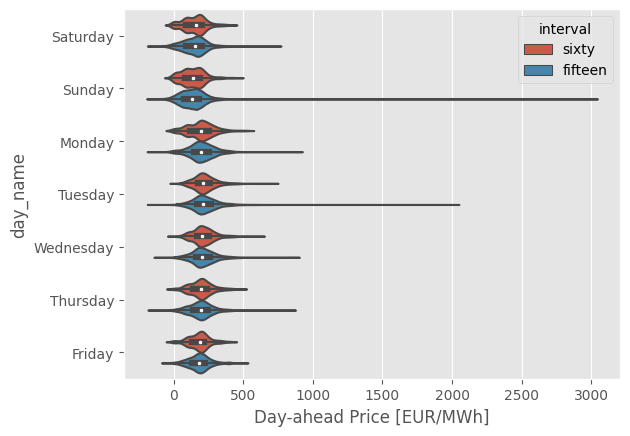

In [83]:
sns.violinplot(data=big_df, x='Day-ahead Price [EUR/MWh]', y="day_name", hue='interval')

<Axes: xlabel='Day-ahead Price [EUR/MWh]', ylabel='day_name'>

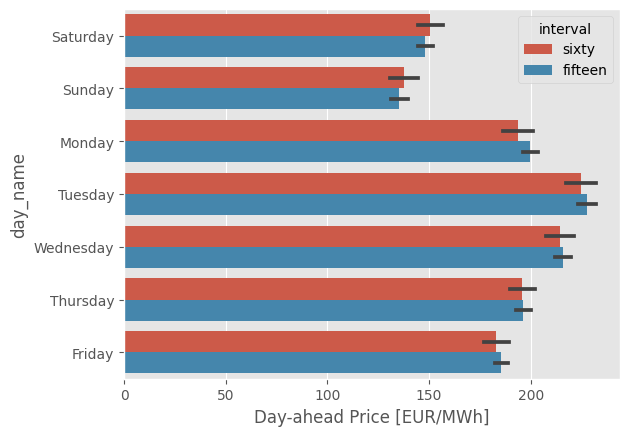

In [84]:
sns.barplot(data=big_df, x='Day-ahead Price [EUR/MWh]', y="day_name", hue='interval', orient='h')
# lower average price for both on week end as compared to weekday
# similar average prices per day

<Axes: xlabel='hour', ylabel='Day-ahead Price [EUR/MWh]'>

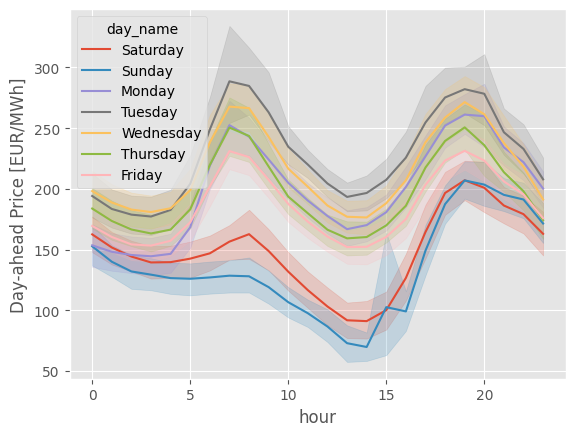

In [85]:
sns.lineplot(data=df_15, x="hour", y='Day-ahead Price [EUR/MWh]', estimator=np.mean, hue='day_name')

<Axes: xlabel='hour', ylabel='Day-ahead Price [EUR/MWh]'>

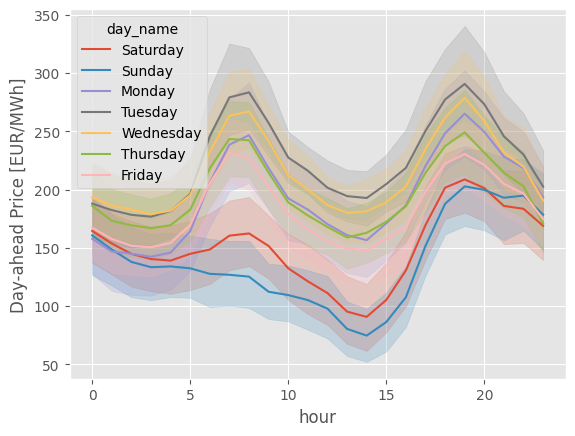

In [86]:
sns.lineplot(data=df_60, x="hour", y='Day-ahead Price [EUR/MWh]', estimator=np.mean, hue='day_name')

In [87]:
# also similar distribution of mean prices by hour
# weekend week day difference is bigger for the 15 minute data

<Axes: xlabel='month_name', ylabel='Day-ahead Price [EUR/MWh]'>

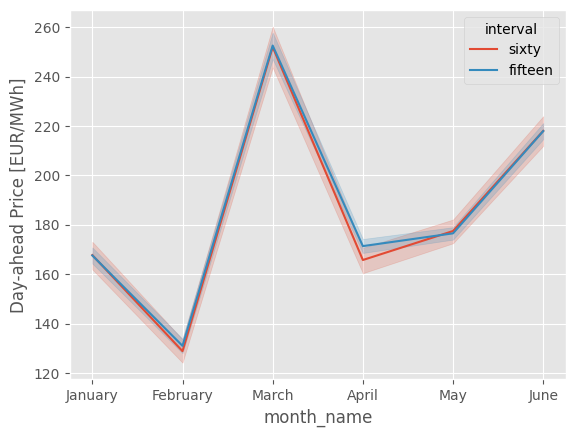

In [88]:
sns.lineplot(data=big_df.reset_index(drop=True), x="month_name", y='Day-ahead Price [EUR/MWh]', estimator=np.mean, hue='interval')
# very similar average prices for each month

<Axes: xlabel='Day-ahead Price [EUR/MWh]', ylabel='month_name'>

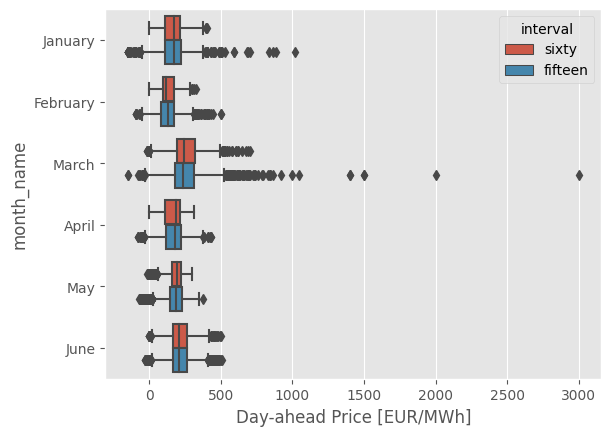

In [89]:
sns.boxplot(data=big_df, x='Day-ahead Price [EUR/MWh]', y="month_name", hue='interval')

### Task 2 Conclusion
Average conditional distribution seem to be similar for both the 60 and 15 min data.
The 15 min data seems more volatile so I would recommend trading in the 60 minute market because it seems a little more predictable